# Lending Club Analysis

In [54]:
# Requirements: pandas, numpy, scikit-learn, xgboost (optional), shap (optional), python-pptx (optional)
# !pip install pandas numpy scikit-learn xgboost shap python-pptx joblib seaborn

In [99]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({"figure.figsize": (8,5), "font.size": 11})
sns.set_style("whitegrid")

# Output folder
OUT = Path.cwd() / "lc_outputs"
OUT.mkdir(parents=True, exist_ok=True)

# CSV path - change if needed
CSV_PATH = Path.cwd() / "Lending Club Data - DR_Demo_Lending_Club.csv"


In [100]:
# ============
# Load data
# ============
print("Loading:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print("Original shape:", df.shape)

# quick peek
display(df.head())
print("Columns:", len(df.columns))

Loading: /Users/sm549c/Downloads/CCS/Lending Club Data - DR_Demo_Lending_Club.csv
Original shape: (10000, 28)


,Id,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1,0,Time Warner Cable,10,MORTGAGE,50000.0,not verified,n,NaN,medical,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,2,0,Ottawa University,1,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using...,debt consolidation,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,3,0,Kennedy Wilson,4,RENT,65000.0,not verified,n,NaN,credit card,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
3,4,0,TOWN OF PLATTEKILL,10,MORTGAGE,57500.0,not verified,n,NaN,debt consolidation,...,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
4,5,0,Belmont Correctional,10,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacat...",debt consolidation,...,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


Columns: 28


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           10000 non-null  int64  
 1   is_bad                       10000 non-null  int64  
 2   emp_title                    9408 non-null   object 
 3   emp_length                   10000 non-null  object 
 4   home_ownership               10000 non-null  object 
 5   annual_inc                   9999 non-null   float64
 6   verification_status          10000 non-null  object 
 7   pymnt_plan                   10000 non-null  object 
 8   Notes                        6769 non-null   object 
 9   purpose_cat                  10000 non-null  object 
 10  purpose                      9996 non-null   object 
 11  zip_code                     10000 non-null  object 
 12  addr_state                   10000 non-null  object 
 13  debt_to_income   

In [102]:
target_col = "is_bad"

print("Using target:", target_col)
print("Target distribution:")
print(df[target_col].value_counts(dropna=False, normalize=True))


Using target: is_bad
Target distribution:
is_bad
0    0.8705
1    0.1295
Name: proportion, dtype: float64


In [103]:
# ======================================
# Basic cleaning & safe column drops
# ======================================
# Drop obvious ID/text columns not useful for modeling
drop_candidates = ["Id","emp_title","Notes","purpose","zip_code","addr_state","mths_since_last_record","pub_rec","initial_list_status",
                   "collections_12_mths_ex_med","mths_since_last_major_derog","policy_code"]

print("Dropping:", drop_candidates)
df = df.drop(columns=drop_candidates)


Dropping: ['Id', 'emp_title', 'Notes', 'purpose', 'zip_code', 'addr_state', 'mths_since_last_record', 'pub_rec', 'initial_list_status', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code']


In [104]:
# Ensure column is in datetime format
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%m/%d/%y')

# Calculate age in years
df['credit_age_years'] = (datetime.now() - df['earliest_cr_line']).dt.days / 365.25

# Handle invalid or missing dates
df['credit_age_years'] = df['credit_age_years'].fillna(df['credit_age_years'].median())

# Check results
print(df[['earliest_cr_line', 'credit_age_years']].head())

  earliest_cr_line  credit_age_years
0       1992-12-01         32.903491
1       2005-11-01         19.986311
2       1970-06-01         55.405886
3       1982-09-01         43.154004
4       1999-10-01         26.072553


In [105]:
# =============================
# Feature selection heuristics 
# =============================
# Choose numeric and categorical features for modeling automatically,
# with safeguards (limit high-cardinality cats).
NUMERIC = df.select_dtypes(include=["int64","float64"]).columns.tolist()
NUMERIC = [c for c in NUMERIC if c != target_col]  # exclude target

CATEGORICAL = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
# limit categorical to those with <= 50 unique values (adjustable)
CATEGORICAL = [c for c in CATEGORICAL if df[c].nunique() <= 50]

# Remove any columns with >95% missing
cols_to_drop = [c for c in df.columns if df[c].isna().mean() > 0.95]
if cols_to_drop:
    print("Dropping >95% missing:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)
    NUMERIC = [c for c in NUMERIC if c not in cols_to_drop]
    CATEGORICAL = [c for c in CATEGORICAL if c not in cols_to_drop]

print("Numeric features chosen:", len(NUMERIC))
print("Categorical features chosen:", len(CATEGORICAL))

# keep final feature lists (you can customize manually)
FEATURES = NUMERIC + CATEGORICAL
print("Total features to use:", len(FEATURES))

Numeric features chosen: 10
Categorical features chosen: 5
Total features to use: 15



--- EDA summary ---
Default rate: 0.1295
Top missing counts:
 mths_since_last_delinq    6316
revol_util                  26
delinq_2yrs                  5
inq_last_6mths               5
open_acc                     5
total_acc                    5
annual_inc                   1
debt_to_income               0
revol_bal                    0
credit_age_years             0
emp_length                   0
home_ownership               0
verification_status          0
pymnt_plan                   0
purpose_cat                  0
dtype: int64


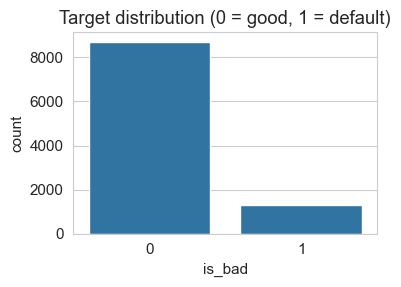

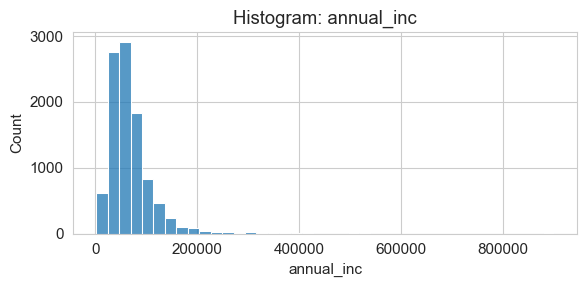

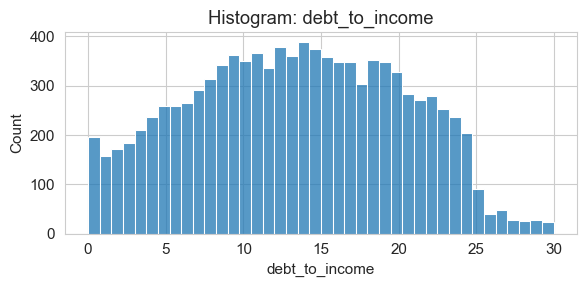

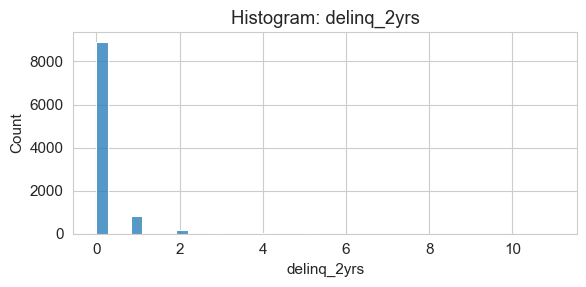

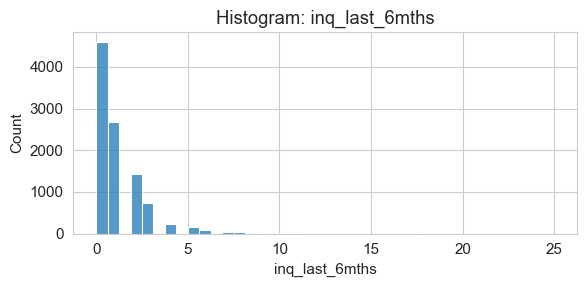

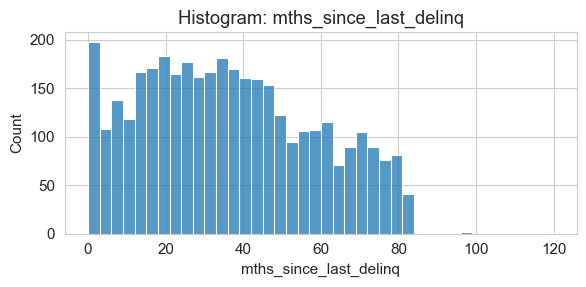

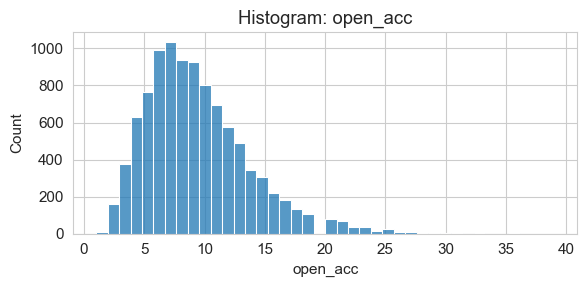

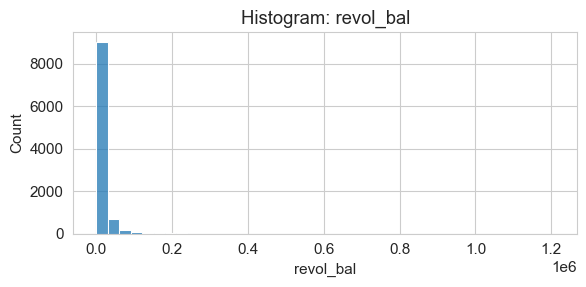

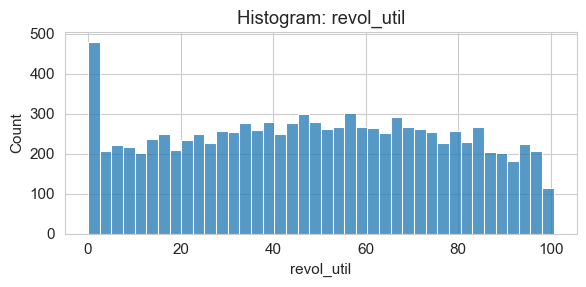

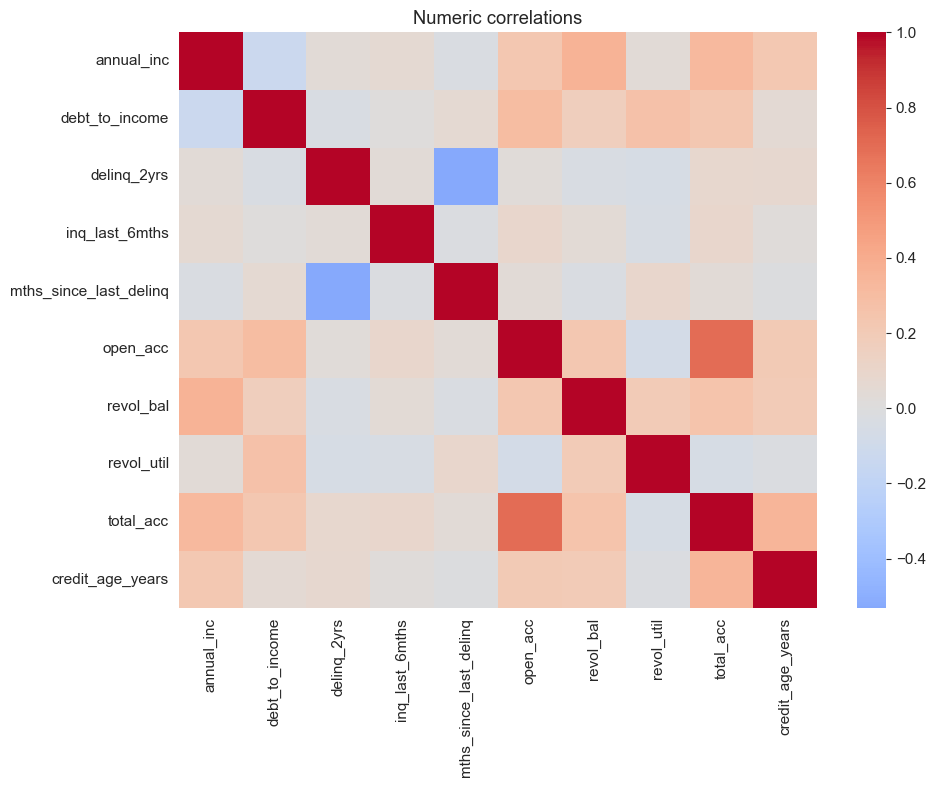

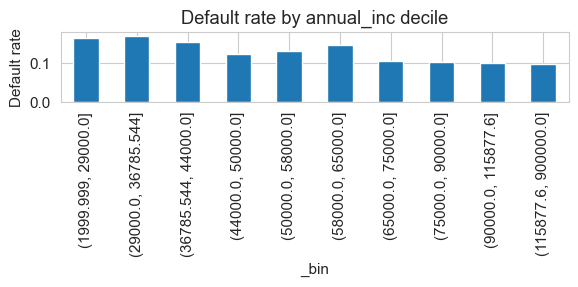

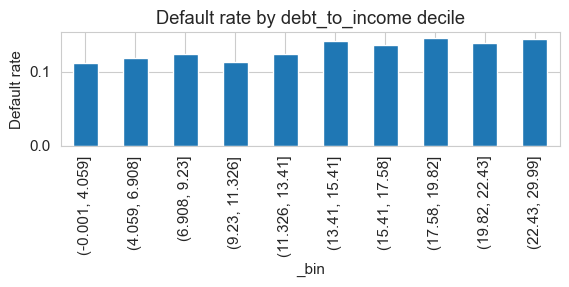

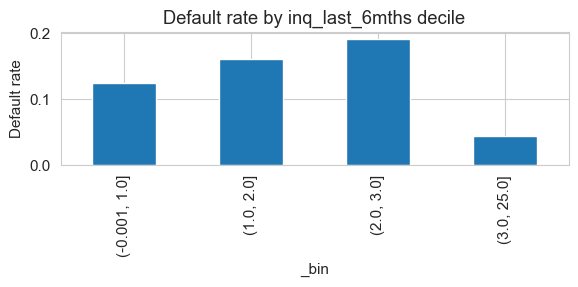

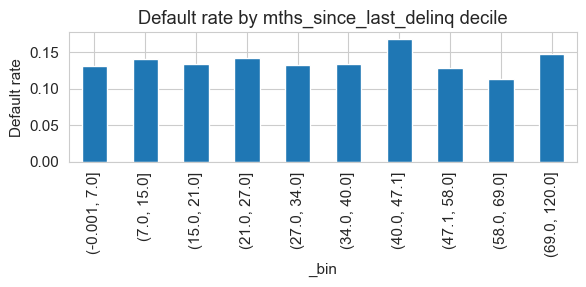

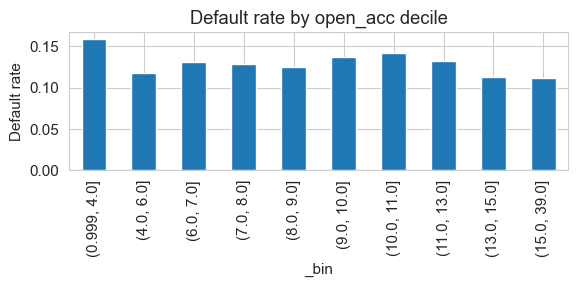

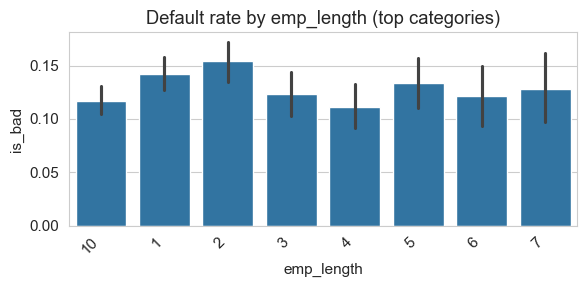

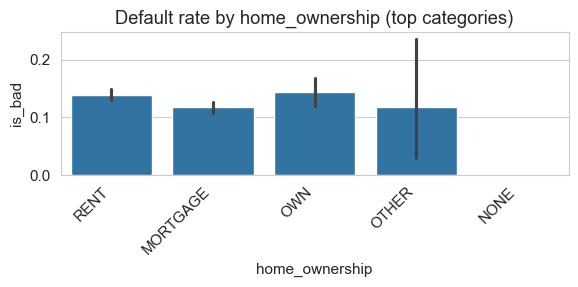

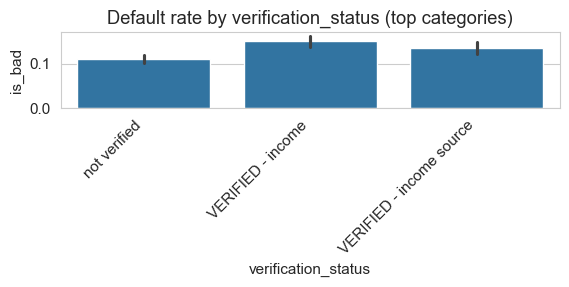

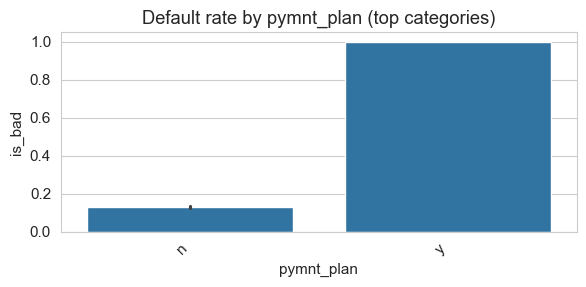

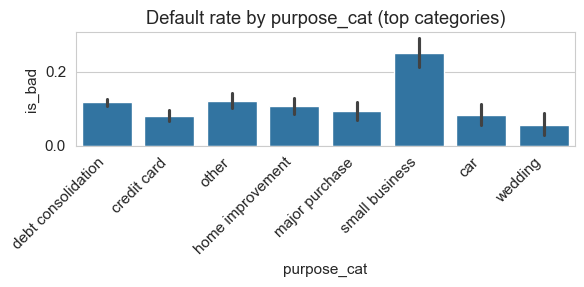

In [106]:
# =================================================================================
# CELL 5: Exploratory Data Analysis (EDA) - visuals saved to OUT/eda/
# =================================================================================
EDA_OUT = OUT / "eda"
EDA_OUT.mkdir(parents=True, exist_ok=True)

# Basic distributions
print("\n--- EDA summary ---")
print("Default rate:", df[target_col].mean())

# Missingness overview (top 15)
missing = df[FEATURES + [target_col]].isna().sum().sort_values(ascending=False)
print("Top missing counts:\n", missing.head(15))

# Target distribution bar
plt.figure(figsize=(4,3))
sns.countplot(x=target_col, data=df)
plt.title("Target distribution (0 = good, 1 = default)")
plt.tight_layout()
# plt.savefig(EDA_OUT / "target_dist.png")
plt.show()

# Numeric histograms (top 8)
n_show = min(8, len(NUMERIC))
for col in NUMERIC[:n_show]:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col].dropna(), bins=40, kde=False)
    plt.title(f"Histogram: {col}")
    plt.tight_layout()
    # plt.savefig(EDA_OUT / f"hist_{col}.png")
    plt.show()

# Correlation heatmap of numeric features (compute on subset to speed)
if len(NUMERIC) >= 2:
    num_corr = df[NUMERIC].corr().abs()
    # pick top correlated to target if target in numeric, else show first 20
    plt.figure(figsize=(10,8))
    sns.heatmap(df[NUMERIC].corr(), cmap="coolwarm", center=0)
    plt.title("Numeric correlations")
    plt.tight_layout()
    # plt.savefig(EDA_OUT / "numeric_corr.png")
    plt.show()

# Numeric feature vs target: binned default rate
for col in NUMERIC[:6]:
    try:
        if df[col].nunique() > 10:
            tmp = df[[col, target_col]].dropna()
            tmp["_bin"] = pd.qcut(tmp[col], q=10, duplicates="drop")
            br = tmp.groupby("_bin")[target_col].mean()
            plt.figure(figsize=(6,3))
            br.plot(kind="bar")
            plt.title(f"Default rate by {col} decile")
            plt.ylabel("Default rate")
            plt.tight_layout()
            # fname = EDA_OUT / f"default_by_{col}.png"
            # plt.savefig(fname)
            plt.show()
    except Exception as e:
        print("Skipped binned plot for", col, "due to", e)

# Categorical vs target (top categories)
for col in CATEGORICAL[:8]:
    plt.figure(figsize=(6,3))
    order = df[col].value_counts().index[:8]
    sns.barplot(x=col, y=target_col, data=df, order=order)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Default rate by {col} (top categories)")
    plt.tight_layout()
    # plt.savefig(EDA_OUT / f"default_by_{col}.png")
    plt.show()

# Save a small EDA CSV summary (corr with target for numeric)
if NUMERIC:
    corr_with_target = df[NUMERIC].corrwith(df[target_col]).sort_values(ascending=False)
    # corr_with_target.to_csv(EDA_OUT / "corr_with_target_numeric.csv")
    # print("Saved corr_with_target_numeric.csv")

# print("EDA images saved to:", EDA_OUT)


In [107]:
# =================================================================================
# CELL 6: Preprocessing pipelines & train/test split
# =================================================================================
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# split
X = df[FEATURES].copy()
y = df[target_col].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("Train / Test:", X_train.shape, X_test.shape)

# numeric pipeline
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# categorical pipeline - use sparse OHE to save memory in larger datasets
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", dtype=np.float32))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, NUMERIC),
        ("cat", cat_transformer, CATEGORICAL),
    ],
    remainder="drop", verbose_feature_names_out=False
)

# Fit-transform once to get output feature dimension (optional safe check)
try:
    preprocessor.fit(X_train)
    # not transforming entire dataset to avoid huge memory usage here
    print("Preprocessor fitted.")
except Exception as e:
    print("Preprocessor fit error:", e)


Train / Test: (7000, 15) (3000, 15)
Preprocessor fitted.


In [108]:
# =================================================================================
# CELL 7: Model training (Logistic Regression, RandomForest, XGBoost/GradBoost)
# =================================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

models = {}

# Logistic Regression (balanced)
pipe_lr = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga"))
])
pipe_lr.fit(X_train, y_train)
models["LogisticRegression"] = pipe_lr
print("Trained LogisticRegression")

# Random Forest
pipe_rf = Pipeline([
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced", n_jobs=-1))
])
pipe_rf.fit(X_train, y_train)
models["RandomForest"] = pipe_rf
print("Trained RandomForest")

# XGBoost
from xgboost import XGBClassifier
pipe_xgb = Pipeline([
    ("preproc", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_estimators=1000, n_jobs=1))
])
pipe_xgb.fit(X_train, y_train)
models["XGBoost"] = pipe_xgb
print("Trained XGBoost")


Trained LogisticRegression
Trained RandomForest
Trained XGBoost


Evaluating: LogisticRegression
Evaluating: RandomForest
Evaluating: XGBoost


,model,accuracy,precision,recall,f1,auc,confusion_matrix
0,LogisticRegression,0.710000,0.236324,0.556701,0.331797,0.697183,"[[1914, 698], [172, 216]]"
2,XGBoost,0.870333,0.496124,0.164948,0.247582,0.649697,"[[2547, 65], [324, 64]]"
1,RandomForest,0.881667,0.971429,0.087629,0.160757,0.689960,"[[2611, 1], [354, 34]]"


Saved model_comparison.csv


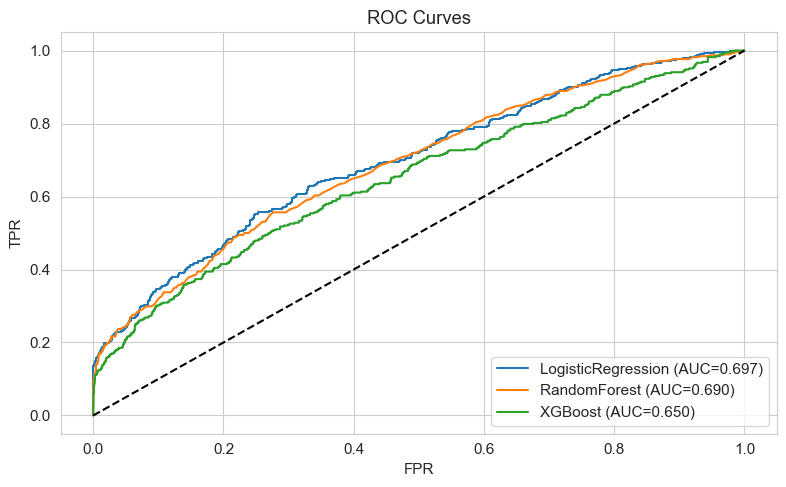

In [109]:
# =================================================================================
# CELL 8: Evaluation helper & results table
# =================================================================================
def evaluate_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    return {"accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"auc":auc,"confusion_matrix":cm.tolist(), "y_proba": y_proba, "y_pred": y_pred}

results_list = []
for name, pipe in models.items():
    print("Evaluating:", name)
    res = evaluate_model(pipe, X_test, y_test)
    res_row = {"model": name, "accuracy": res["accuracy"], "precision": res["precision"],
               "recall": res["recall"], "f1": res["f1"], "auc": res["auc"], "confusion_matrix": res["confusion_matrix"]}
    results_list.append(res_row)
    
results_df = pd.DataFrame(results_list).sort_values(by="f1", ascending=False)
display(results_df)
results_df.to_csv(OUT / "model_comparison.csv", index=False)
print("Saved model_comparison.csv")

# Plot ROC curves if probabilities available
from sklearn.metrics import roc_curve, auc
plt.figure()
for name, pipe in models.items():
    try:
        y_proba = pipe.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    except Exception:
        continue
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(OUT / "roc_curves.png")
plt.show()

Using tree model for importances: XGBoost


,feature,importance
0,purpose_cat_debt consolidation small business,0.341489
1,purpose_cat_credit card small business,0.127867
2,purpose_cat_other small business,0.089663
3,purpose_cat_small business small business,0.085437
4,purpose_cat_home improvement small business,0.082452
5,purpose_cat_small business,0.024817
6,emp_length_8,0.016041
7,delinq_2yrs,0.013291
8,emp_length_4,0.011900
9,home_ownership_OWN,0.010910


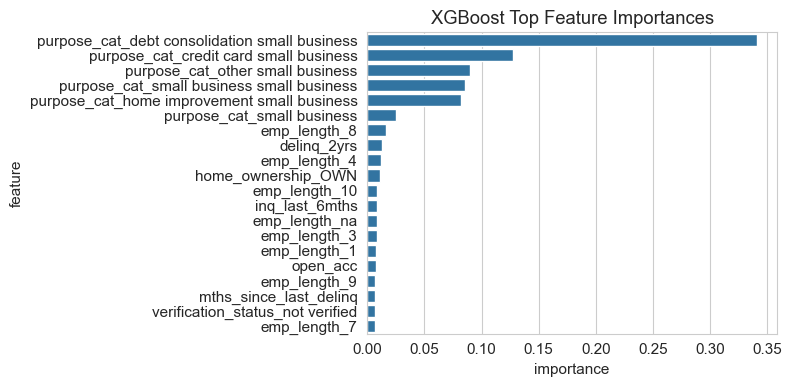

SHAP available; computing SHAP values (sampled). This may take some time.
Failed to compute SHAP summary plot: bad operand type for abs(): 'Explanation'


In [110]:
# =================================================================================
# CELL 9: Feature importance (tree models) & SHAP interpretation (if available)
# =================================================================================
# Feature importance: we will attempt to map transformed indices back to feature names for OHE columns.
def get_feature_names(preproc, numeric_features, categorical_features):
    # numeric names are straightforward
    names = []
    if "num" in dict(preproc.named_transformers_):
        names.extend(numeric_features)
    # for categorical, best-effort to retrieve OHE output names
    if "cat" in dict(preproc.named_transformers_):
        cat_trans = preproc.named_transformers_["cat"]
        ohe = None
        # cat_trans is a Pipeline(imputer,ohe)
        for step_name, step in cat_trans.named_steps.items():
            if step_name == "ohe":
                ohe = step
                break
        if ohe is not None:
            try:
                ohe_names = ohe.get_feature_names_out(categorical_features).tolist()
            except:
                # fallback to manual expanded names
                ohe_names = []
                for c in categorical_features:
                    vals = df[c].dropna().unique()[:10]
                    for v in vals:
                        ohe_names.append(f"{c}__{v}")
            names.extend(ohe_names)
    return names

# choose a tree model if present
tree_model_name = None
for nm in ["XGBoost","GradBoost","RandomForest"]:
    if nm in models:
        tree_model_name = nm
        break

if tree_model_name:
    print("Using tree model for importances:", tree_model_name)
    tree_pipe = models[tree_model_name]
    clf = tree_pipe.named_steps["clf"]
    importances = getattr(clf, "feature_importances_", None)
    if importances is not None:
        # get preproc feature names
        fnames = get_feature_names(tree_pipe.named_steps["preproc"], NUMERIC, CATEGORICAL)
        # if length mismatch, fall back to index names
        if len(fnames) != len(importances):
            print("Feature name length mismatch; using indices")
            items = sorted(list(enumerate(importances)), key=lambda x: -x[1])[:20]
            imp_df = pd.DataFrame([{"feature_index": int(i), "importance": float(v)} for i,v in items])
        else:
            idx = np.argsort(-importances)[:20]
            imp_df = pd.DataFrame([{"feature": fnames[i], "importance": float(importances[i])} for i in idx])
        imp_df.to_csv(OUT / f"{tree_model_name}_feature_importances.csv", index=False)
        display(imp_df.head(20))
        # bar plot
        plt.figure(figsize=(8,4))
        if "feature" in imp_df.columns:
            sns.barplot(x="importance", y="feature", data=imp_df)
            plt.title(f"{tree_model_name} Top Feature Importances")
        else:
            sns.barplot(x="importance", y="feature_index", data=imp_df)
            plt.title(f"{tree_model_name} Top Feature Importances (indices)")
        plt.tight_layout()
        plt.savefig(OUT / f"{tree_model_name}_importances.png")
        plt.show()
    else:
        print("No feature_importances_ in classifier.")

# SHAP: global and per-sample explanation (best-effort; may be slow)
try:
    import shap
    shap_available = True
    print("SHAP available; computing SHAP values (sampled). This may take some time.")
    # pick the best tree model if possible, otherwise use logistic for linear explainer
    best_name = results_df.iloc[0]["model"]
    best_pipe = models[best_name]
    clf = best_pipe.named_steps["clf"]
    # use sample for speed
    X_shap = X_test.sample(min(1000, len(X_test)), random_state=42)
    X_shap_trans = best_pipe.named_steps["preproc"].transform(X_shap)
    if "XGB" in clf.__class__.__name__ or hasattr(clf, "booster") or "Tree" in str(type(clf)):
        expl = shap.TreeExplainer(clf)
        shap_vals = expl.shap_values(X_shap_trans)
    else:
        expl = shap.Explainer(clf, X_shap_trans)
        shap_vals = expl(X_shap_trans)
    # compute mean abs shap for features
    try:
        feature_names = get_feature_names(best_pipe.named_steps["preproc"], NUMERIC, CATEGORICAL)
        mean_abs = np.mean(np.abs(shap_vals), axis=0)
        top_idx = np.argsort(-mean_abs)[:20]
        shap_summary = [{"feature": feature_names[i] if i < len(feature_names) else f"f_{i}", "mean_abs_shap": float(mean_abs[i])} for i in top_idx]
        pd.DataFrame(shap_summary).to_csv(OUT / f"{best_name}_shap_summary.csv", index=False)
        print("Saved SHAP summary to outputs.")
        # SHAP summary plot (global)
        shap.summary_plot(shap_vals, X_shap_trans, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(OUT / f"{best_name}_shap_summary.png", bbox_inches="tight")
        plt.close()
    except Exception as e:
        print("Failed to compute SHAP summary plot:", e)
except Exception as e:
    print("SHAP not available or failed: ", e)
    shap_available = False
